# Word Embedding

Word Embedding is a type of word representation that allows words with similar meaning to have a similar representation. It is a learned representation for text where words that have the same meaning have a similar representation. The process of creating word embeddings is to train a model on a large body of text using unsupervised learning so that it learns to predict a word given its context, or vice versa. This results in embeddings where words that are close together in the high-dimensional embedding space are expected to be semantically similar.

Notably, word embeddings do not just assign each word to a unique vector, but they actually represent words in a way that captures semantic or syntactic similarity, based on the text corpus the model is trained on. Embedding vectors are often hundreds of dimensions and are good at capturing nuanced relationships between words.

![word_embed](../asset/word_embed.png)

## Embedding layer

An Embedding Layer in machine learning is a layer that creates word embeddings from input sequences by mapping words or integers to dense vectors of real numbers. It's often used in natural language processing tasks where the layer takes in a 2D input of integer sequences (word indices) and on output provides 3D floating point tensor sequences. Each individual sequence in the 3D output tensor will have the same length as the original input sequence, but each word or integer in the sequence is now represented by a dense vector. These vectors capture semantic relationships between words, and their dimensionality is a hyperparameter that can be tuned for specific tasks.

### Very basic usage

Embedding is just a simple lookup table. Link a index to a trainable vector.

In [1]:
import torch
import torch.nn as nn

word_to_ix = {"hello": 0, "world": 1}

# 2 words in vocab "hello" and "world"
# 5 dimensional embeddings
embeds = nn.Embedding(num_embeddings=2, embedding_dim=5)

lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)

hello_embed = embeds(lookup_tensor)

print(hello_embed)

tensor([[ 2.1202, -0.2036, -0.0226,  1.2910,  1.8117]],
       grad_fn=<EmbeddingBackward0>)


Get train parameters


In [2]:
for param in embeds.parameters():
    print(param)

Parameter containing:
tensor([[ 2.1202, -0.2036, -0.0226,  1.2910,  1.8117],
        [-0.3365,  1.5382,  1.6419,  1.2614, -0.4843]], requires_grad=True)


Just for fun set weight to a fix value


In [3]:
embedding_lookup = torch.tensor([
    [1, 0, 0, 0, 1],
    [0, 1, 1, 1, 0],
], dtype=torch.float32)
embeds.weight = nn.Parameter(embedding_lookup)
embeds.weight

Parameter containing:
tensor([[1., 0., 0., 0., 1.],
        [0., 1., 1., 1., 0.]], requires_grad=True)

As you can see, if I select index 0 or 1, I get my embedding_lookup line.


In [4]:
print(embeds(torch.tensor([0])))
print(embeds(torch.tensor([1])))

tensor([[1., 0., 0., 0., 1.]], grad_fn=<EmbeddingBackward0>)
tensor([[0., 1., 1., 1., 0.]], grad_fn=<EmbeddingBackward0>)


## GPT embedding

Let's get the very first GPT model and see how the embedding layer size

In [6]:
from transformers import GPT2Tokenizer, GPT2Model

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")

print("vocab size", tokenizer.vocab_size)

# expected Embedding(50257, 768)
# 50257 = vocabulary size
# 768 = number of features
print("Embedding size", model.wte)

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

vocab size 50257
Embedding size Embedding(50257, 768)



[Let's look at the code for this model](https://github.com/huggingface/transformers/blob/v4.25.1/src/transformers/models/gpt2/modeling_gpt2.py#L667)

## Train first embedding layer

For this part we will train our first embedding layer on disney park reviews !

To start we will ony train this layer on letter instance of words



In [7]:
import pandas as pd

# Load and take subset of the dataset
df = pd.read_csv("train.csv")[:5000]
df.head()

,Unnamed: 0,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,16833,333121929,5,2015-12,United States,Truly the most magical place on the West Coast...,Disneyland_California
1,28602,71690002,5,missing,Canada,"I cry every time we have to leave this place, ...",Disneyland_California
2,32094,481683772,5,2017-4,United Kingdom,"Staff everywhere were just friendly, the custo...",Disneyland_Paris
3,16576,339637317,5,2016-1,United States,"It's Disneyland, what more is there to say? W...",Disneyland_California
4,13962,438710000,5,2016-10,United Kingdom,We visited this park at Halloween and enjoyed ...,Disneyland_California


In [8]:
# Count each deffrent values of rating
df['Rating'].value_counts()

Rating
5    2662
4    1274
3     610
2     260
1     194
Name: count, dtype: int64

In [9]:
# Get reviews
reviews = df["Review_Text"].values.tolist()

In [11]:
reviews[:5]

['Truly the most magical place on the West Coast. This is my second trip to disneyland. I absolutely love this place great for adults, kids, couples, and family. Highly recommended.',
 "I cry every time we have to leave this place, so much love and magic is in the Disneyland Resort. It's one of those places you'd never get bored in...it's spectacular. It's one of the only places I feel like a kid again..and I think everyone should come here once.",
 "Staff everywhere were just friendly, the customer service is just top notch everywhere!It does help to speak French but there's lots of staff who are multilingual so we spoke Italian and German a few times!One of the best presents I bought my partner and she loved it all over!",
 "It's Disneyland, what more is there to say?  Walt's park opened in 1955 and has been delighting guests for 60 years now.  So many great rides and so much fun to be had.",
 "We visited this park at Halloween and enjoyed the Halloween parade and trick or treating.I

Now we will creat an sequence of letter based on sentences

For example:

```
aba decides a
```

will produce

```
[
  ('a', 'b'),
  ('b', 'a'),
  ('a', ' '),
  (' ', 'd'),
  ('d', 'e'),
  ('e', 'c'),
  ('c', 'i'),
  ('i', 'd'),
  ('d', 'e'),
  ('e', 's'),
  ('s', ' '),
  (' ', 'a'),
]
```

On prend deux lettres par deux au lieu de 1

In [43]:
import itertools as it
import re


def sliding_window(txt):
    for i in range(len(txt) - 2):
        yield txt[i:i+2], txt[i + 2]


window = []
for title in reviews:
    # Get only a to z and 0 to 9 letters and numerb
    title = re.sub('[^a-zA-Z0-9]+', '', title.lower())
    window.append(sliding_window(title))
window = list(it.chain(*window))

# Number of window
print(len(window))
# Get first 5 example
window[:5]

2694406


[('tr', 'u'), ('ru', 'l'), ('ul', 'y'), ('ly', 't'), ('yt', 'h')]

On cherche a avoir avec le mapping {'u': 0, 'l': 1, 'y': 2, 't': 3, ..., 'r': 17, ...} 
un integers_in in de la forme [3, 17]
et un integers_out de la forme 0

In [55]:
import numpy as np

# get the first value
mapping = {c: i for i, c in enumerate(pd.DataFrame(window)[1].unique())}

integers_in = np.array([[mapping[w[0][0]], mapping[w[0][1]]] for w in window])
integers_out = np.array([mapping[w[1]] for w in window])

print("Shape of input", integers_in.shape)
print("Input example in:", integers_in[0], "out: ", integers_out[0])
print("Show generate mapping\n", mapping)

Shape of input (2694406, 2)
Input example in: [ 3 17] out:  0
Show generate mapping
 {'u': 0, 'l': 1, 'y': 2, 't': 3, 'h': 4, 'e': 5, 'm': 6, 'o': 7, 's': 8, 'a': 9, 'g': 10, 'i': 11, 'c': 12, 'p': 13, 'n': 14, 'w': 15, 'd': 16, 'r': 17, 'b': 18, 'v': 19, 'f': 20, 'k': 21, 'j': 22, '1': 23, '9': 24, '5': 25, '6': 26, '0': 27, 'q': 28, '7': 29, '2': 30, 'x': 31, 'z': 32, '3': 33, '4': 34, '8': 35}


### The dataset class
The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: __getitem__, and __len__. The get-item function has to return the i-th data point in the dataset, while the len function returns the size of the dataset.

In [97]:
import torch.utils.data as data


class NextLetterDataset(data.Dataset):

    def __init__(self, integers_in, integers_out):
        self.integers_in = integers_in
        self.integers_out = integers_out

    def __len__(self):
        # Number of data pin dataset
        return len(self.integers_in)

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.integers_in[idx]
        data_label = self.integers_out[idx]
        return torch.tensor(data_point), torch.tensor(data_label, dtype=torch.long)

### Build first embedding model

We will build a simple network to do next letter prediction

![next letter](../asset/next_letter_prediction.png)

On change le model pour qu'il prenne en compte les deux lettres -> embedding_size*2

In [105]:
import torch.nn.functional as F


class NextLetterPrediction(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(NextLetterPrediction, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
        # On multiplie l'embending par deux car on prend deux lettres (*3 si on prend 3 lettres)...
        self.fc = torch.nn.Linear(embedding_size*2, vocab_size)

    def forward(self, x):
        x = F.relu(self.embedding(x))
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

### Plot letter before the train

Let's plot letter embedding before to train the model

In [106]:
model = NextLetterPrediction(vocab_size=len(mapping),
                             # For X and Y plot
                             embedding_size=2)

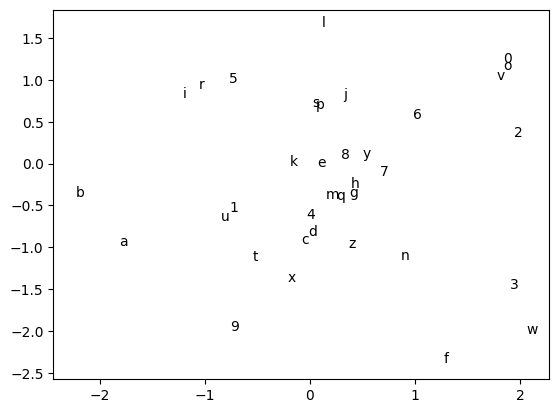

In [100]:
import matplotlib.pylab as plt

idx_to_calc = list(mapping.values())
idx_to_calc = np.array([idx_to_calc]).T

translator = {v: k for k, v in mapping.items()}
preds = model.embedding(torch.tensor(idx_to_calc)).detach().numpy()
plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
    plt.text(preds[i, 0, 0], preds[i, 0, 1], translator[idx[0]])

### Train loop


In [101]:
# Init the dataset into the DataLoader
dataset = NextLetterDataset(integers_in, integers_out)
trainloader = data.DataLoader(dataset, batch_size=128, shuffle=True)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [102]:
epoches = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Load the model to cuda device in train mode
model.to(device)
model.train()
# loop over the dataset multiple times
for epoch in range(epoches):

    running_loss = 0.0
    for i, batch in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

cuda
[1,  2000] loss: 2.836
[1,  4000] loss: 2.787
[1,  6000] loss: 2.787
[1,  8000] loss: 2.786
[1, 10000] loss: 2.789
[1, 12000] loss: 2.786
[1, 14000] loss: 2.786
[1, 16000] loss: 2.786
[1, 18000] loss: 2.786
[1, 20000] loss: 2.791
Finished Training


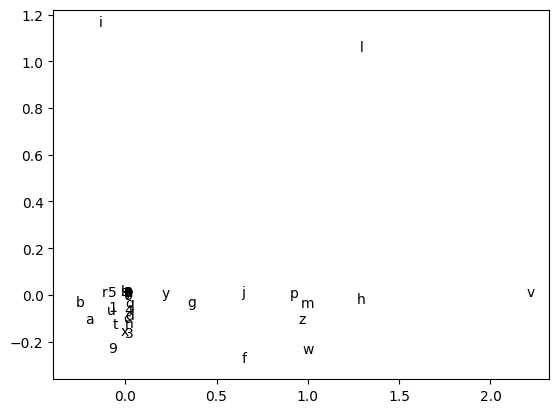

In [103]:
idx_to_calc = list(mapping.values())
idx_to_calc = np.array([idx_to_calc]).T

translator = {v: k for k, v in mapping.items()}
preds = model.embedding(torch.tensor(idx_to_calc).to(device)).cpu().detach().numpy()
plt.scatter(preds[:, 0, 0], preds[:, 0, 1], alpha=0)
for i, idx in enumerate(idx_to_calc):
    plt.text(preds[i, 0, 0], preds[i, 0, 1], translator[idx[0]])

In [104]:
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

# Set the model in evaluation mode
model.eval()

true_labels = []
predictions = []

# Disabling gradient calculation
with torch.no_grad():
    for data in tqdm(trainloader):
        images, labels = data

        # Send inputs to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        predicted = torch.argmax(outputs.data, 1)
        # Store results
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Generate classification report
report = classification_report(true_labels, predictions)
print(report)

  0%|          | 0/21051 [00:00<?, ?it/s]

/home/rom/Documents/MATH904/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rom/Documents/MATH904/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     78534
           1       0.01      0.00      0.00    108778
           2       0.00      0.00      0.00     68856
           3       0.11      0.61      0.19    248345
           4       0.00      0.00      0.00    126657
           5       0.24      0.53      0.33    333179
           6       0.00      0.00      0.00     57238
           7       0.00      0.00      0.00    198014
           8       0.00      0.00      0.00    173233
           9       0.00      0.00      0.00    232354
          10       0.00      0.00      0.00     53525
          11       0.00      0.00      0.00    186092
          12       0.00      0.00      0.00     62302
          13       0.00      0.00      0.00     54340
          14       0.22      0.32      0.26    178736
          15       0.00      0.00      0.00     68642
          16       0.00      0.00      0.00    121492
          17       0.21    

/home/rom/Documents/MATH904/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
